## The Approve or Reject Pattern

### 1. Core Imports and Setup

In [38]:
from dotenv import load_dotenv

from typing import Literal, TypedDict
import uuid
from pprint import pprint
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
# from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

model = ChatOpenAI()

# Pretty print function for displaying state and events
def pretty_print(obj):
    """Pretty print dictionaries and other objects"""
    pprint(obj, width=100, depth=None)


### 2. State Definition

The state is a TypedDict that maintains the shared data across all nodes in the graph. Here we track the LLM's output and the human's decision.


In [39]:
# Define the shared graph state
class State(TypedDict):
    user_prompt: str
    llm_output: str
    decision: str


### 3. LLM Output Generation


In [40]:
# Generate content using LLM
def generate_llm_output(state: State) -> State:
    """Generate content using LLM"""
    try:
        # Use the user_prompt if provided, otherwise use a default
        prompt = state.get("user_prompt", "Write a short story about a robot")
        
        response = model.invoke(prompt)
        # FIX: Extract only the text content, not the entire response object
        generated_text = response.content if hasattr(response, 'content') else str(response)
        
        return {"llm_output": generated_text}
    except Exception as e:
        return {"llm_output": f"Error generating content: {str(e)}"}


### 4. Human Approval Node - The Heart of the Pattern


**How `interrupt` Works:**

1. **Pauses Execution**: When `interrupt()` is called, the graph stops executing and returns control to the caller.
2. **Returns Context**: The interrupt returns a dictionary with the question and relevant data for human review.
3. **Awaits Input**: The graph waits for human input to be provided when resuming.

**Important Note about the `decision` variable:**
The `decision` variable receives the value that was passed in the `Command(resume="...")` when the graph is resumed. So when we call `graph.invoke(Command(resume="approve"), config=config)`, the string `"approve"` becomes the value of `decision`. This is why we can compare it with `decision == "approve"` - it's indeed a string that contains whatever value was passed in the resume command.

**How `Command` Works:**
The `Command` object is a powerful control flow mechanism that serves two purposes:

- **`goto`**: Directs the graph to jump to a specific named node
- **`update`**: Updates the shared state with new values

The type annotation `Command[Literal["approved_path", "rejected_path"]]` ensures type safety by specifying exactly which nodes this command can navigate to.

In [41]:

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    """Present content to human for approval"""
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })
    
    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})


### 5. Conditional Path Nodes

These nodes represent the different paths the workflow can take based on human decision.


In [42]:

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

### 6. Graph Construction

In [43]:
# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

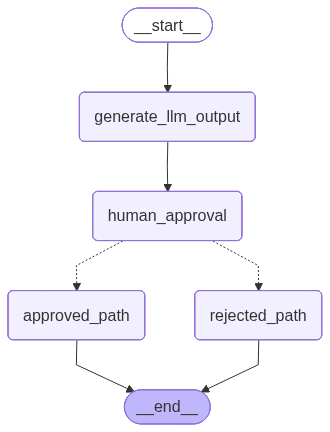

In [44]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [60]:
# Create a unique thread ID
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

# Start with a user prompt
initial_state = {"user_prompt": "Write one line introduction to machine learning for beginners"}
    

In [61]:
for event in graph.stream(initial_state,config,stream_mode="values"):
    # print(event)
    pretty_print(event)


{'user_prompt': 'Write one line introduction to machine learning for beginners'}
{'llm_output': 'Machine learning is a field of artificial intelligence that enables computers to '
               'learn and improve from experience without being explicitly programmed.',
 'user_prompt': 'Write one line introduction to machine learning for beginners'}
{'__interrupt__': (Interrupt(value={'llm_output': 'Machine learning is a field of artificial '
                                                  'intelligence that enables computers to learn '
                                                  'and improve from experience without being '
                                                  'explicitly programmed.',
                                    'question': 'Do you approve the following output?'},
                             id='9b9bfd9b4b6109d32704b1313061a76b'),),
 'llm_output': 'Machine learning is a field of artificial intelligence that enables computers to '
               'learn and i

In [62]:
### check the current state of the graph
state=graph.get_state(config)
pretty_print(state)

StateSnapshot(values={'user_prompt': 'Write one line introduction to machine learning for beginners', 'llm_output': 'Machine learning is a field of artificial intelligence that enables computers to learn and improve from experience without being explicitly programmed.'}, next=('human_approval',), config={'configurable': {'thread_id': '10ec221a-33ac-4ba8-87e8-33b6f8bc73b6', 'checkpoint_ns': '', 'checkpoint_id': '1f0f0098-79e9-6721-8001-ca78507af6ae'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}, 'thread_id': '10ec221a-33ac-4ba8-87e8-33b6f8bc73b6'}, created_at='2026-01-12T22:53:36.917481+00:00', parent_config={'configurable': {'thread_id': '10ec221a-33ac-4ba8-87e8-33b6f8bc73b6', 'checkpoint_ns': '', 'checkpoint_id': '1f0f0098-6c85-62cf-8000-8aaa408fe158'}}, tasks=(PregelTask(id='a186f656-2573-8ed7-1681-f96230a4b420', name='human_approval', path=('__pregel_pull', 'human_approval'), error=None, interrupts=(Interrupt(value={'question': 'Do you approve the following output?', 'llm_

In [63]:
### check the next state
state.next

('human_approval',)

In [64]:
 # Simulate human decision (you can change this to "reject" to test)
human_decision = "approve"  # or "reject"
print(f"\n Simulating human decision: {human_decision}")

# Resume with human input
final_result = graph.invoke(Command(resume=human_decision), config=config)
print(f"\n Final result: {final_result}")


 Simulating human decision: approve
✅ Approved path taken.

 Final result: {'user_prompt': 'Write one line introduction to machine learning for beginners', 'llm_output': 'Machine learning is a field of artificial intelligence that enables computers to learn and improve from experience without being explicitly programmed.', 'decision': 'approved'}


In [65]:
print(f"Decision made: {final_result.get('decision', 'N/A')}")
print(f"LLM Output: {final_result.get('llm_output', 'N/A')[:100]}...")

Decision made: approved
LLM Output: Machine learning is a field of artificial intelligence that enables computers to learn and improve f...


## 2. Edit and Review Pattern

### 1: Setting Up Dependencies


In [66]:
from dotenv import load_dotenv
from typing import TypedDict
import uuid
from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import MemorySaver
# from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
load_dotenv()


True

### 2: Initialize the AI Model & define the state

In [67]:
# Initialize Gemini 2.0 flash model
load_dotenv()

model = model = ChatOpenAI()

# Define the graph state
class State(TypedDict):
    summary: str

### 3: AI Content Generation Node


In [68]:
# Generate summary using LLM
def generate_summary(state: State) -> State:
    """Generate a summary using LLM"""
    
    # Create a simple prompt for demonstration
    prompt = "Write a brief summary about a cat sitting on a mat."
    
    try:
        # Call the model
        response = model.invoke(prompt)
        summary = response.content
        
        return {
            "summary": summary
        }
        
    except Exception as e:
        print(f"Error calling Gemini: {e}")
        # Fallback to original hardcoded summary
        return {
            "summary": "The cat sat on the mat and looked at the stars."
        }

### 4: Human Review and Edit Node

In [69]:
# Human editing node
def human_review_edit(state: State) -> State:
    """Allow human to review and edit the AI-generated summary"""
    
    result = interrupt({
        "task": "Please review and edit the generated summary if necessary.",
        "generated_summary": state["summary"]
    })
    
    return {
        "summary": result["edited_summary"]
    }


### 5: Downstream Processing Node

In [70]:

# Simulate downstream use of the edited summary
def downstream_use(state: State) -> State:
    """Process the final summary"""
    print(f"✅ Using edited summary: {state['summary']}")
    return state


### 6: Building the Graph


In [71]:
# Build the graph
def create_summary_review_graph():
    """Create and return the configured LangGraph"""
    
    builder = StateGraph(State)
    
    # Add nodes
    builder.add_node("generate_summary", generate_summary)
    builder.add_node("human_review_edit", human_review_edit)
    builder.add_node("downstream_use", downstream_use)
    
    # Set entry point
    builder.set_entry_point("generate_summary")
    
    # Add edges
    builder.add_edge("generate_summary", "human_review_edit")
    builder.add_edge("human_review_edit", "downstream_use")
    builder.add_edge("downstream_use", END)
    
    # Set up in-memory checkpointing for interrupt support
    checkpointer = MemorySaver()
    
    return builder.compile(checkpointer=checkpointer)


### 7: Executing the Workflow


In [72]:
# Create the graph
graph = create_summary_review_graph()


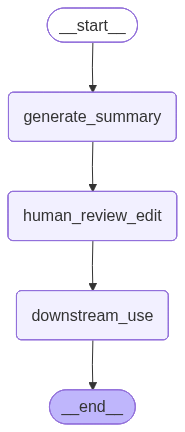

In [73]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [27]:
# Generate unique thread ID for this execution
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

In [74]:
# Step 1: Invoke the graph until it hits the interrupt
print("Step 1: Generating AI summary...")
result = graph.invoke({}, config=config)

Step 1: Generating AI summary...


In [75]:
print(result)

{'summary': 'In this simple and peaceful scene, a fluffy grey cat is seen curled up comfortably on a soft, colorful mat. The cat appears content and relaxed, enjoying the warmth and comfort of its cozy spot. Its eyes are closed as it rests, completely at ease in its surroundings. The sight of the cat sitting on the mat brings a sense of tranquility and calm to the room, creating a serene and peaceful atmosphere.', '__interrupt__': [Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'In this simple and peaceful scene, a fluffy grey cat is seen curled up comfortably on a soft, colorful mat. The cat appears content and relaxed, enjoying the warmth and comfort of its cozy spot. Its eyes are closed as it rests, completely at ease in its surroundings. The sight of the cat sitting on the mat brings a sense of tranquility and calm to the room, creating a serene and peaceful atmosphere.'}, id='69fbffec4b3ac7ba6fdb5aeddad60053')]}


In [76]:
interrupt_data = result["__interrupt__"]
interrupt_data

[Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'In this simple and peaceful scene, a fluffy grey cat is seen curled up comfortably on a soft, colorful mat. The cat appears content and relaxed, enjoying the warmth and comfort of its cozy spot. Its eyes are closed as it rests, completely at ease in its surroundings. The sight of the cat sitting on the mat brings a sense of tranquility and calm to the room, creating a serene and peaceful atmosphere.'}, id='69fbffec4b3ac7ba6fdb5aeddad60053')]

### 8: Human Intervention


In [77]:
# Simulate human editing (in a real application, this would be user input)
print("Step 2: Human reviewing and editing...")
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."

Step 2: Human reviewing and editing...


In [78]:
# Step 3: Resume the graph with edited input
print("Step 3: Resuming workflow with edited summary...")
final_result = graph.invoke(
    Command(resume={"edited_summary": edited_summary}),
    config=config
)

Step 3: Resuming workflow with edited summary...
✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
